In [6]:
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np


In [2]:
IMG_SIZE=32
EMBED_DIM=64
ATTENTION_HEADS=4
BATCH_SIZE=12
EPOCHS=10
LR=3e-4
TEMPERATURE=0.07
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Synthetic dataset properties
colors = ['red','green','blue','yellow','purple','orange','pink','brown','gray']
shapes=['square','circle','triangle']
positions=['left','center','right','top','bottom','top-left','top-right','bottom-left','bottom-right']

In [5]:
#Drawing image shapes
def draw_sample(color,shape,position,img_size=IMG_SIZE):
  img=Image.new('RGB',(img_size,img_size),'white')
  draw=ImageDraw.Draw(img)
  margin=6
  w=h=img_size-2*margin

  #calculate x-coordinates
  if 'left' in position:
    x0=margin
    x1=margin+w//2
  elif 'top-left' in position:
    x0=margin
    x1=margin+w//2
  elif 'bottom-left' in position:
    x0=margin
    x1=margin+w//2
  elif 'right' in position:
    x0=margin+w//2
    x1=img_size-margin
  elif 'top-right' in position:
    x0=margin+w//2
    x1=img_size-margin
  elif 'bottom-right' in position:
    x0=margin+w//2
    x1=img_size-margin
  else:
    x0=margin+w//4
    x1=margin+3*w//4

  #calculate y coordinates:
  if 'top' in position:
    y0=margin
    y1=margin+h//2
  elif 'top-left' in position:
    y0=margin
    y1=margin+h//2
  elif 'top-right' in position:
    y0=margin
    y1=margin+h//2
  elif 'bottom' in position:
    y0=margin+h//2
    y1=img_size-margin
  elif 'bottom-left' in position:
    y0=margin+h//2
    y1=img_size-margin
  elif 'bottom-right' in position:
    y0=margin+h//2
    y1=img_size-margin
  else:
    y0=margin+h//4
    y1=margin+3*h//4

  if shape=='rectangle':
    draw.rectangle([x0,y0,x1,y1],fill=color,outline='black')
  elif shape=='circle':
    draw.ellipse([x0,y0,x1,y1],fill=color,outline='black')
  else:
    draw.polygon([(x0+(x1-x0)//2,y0),(x0,y1),(x1,y1)],fill=color,outline='black')

  return img


In [9]:
# Class for building dataset
class ShapesDataset:
    def __init__(self):
        self.images = []
        self.captions = []

        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p)
                    caption = f"{c} {s} {p}"

                    # here permute is used to arrange red,green,blue in order
                    # Convert PIL/numpy image → torch tensor (C,H,W) and normalize to [0,1]
                    self.images.append(
                        torch.from_numpy(np.asarray(img))
                        .permute(2, 0, 1)          # HWC → CHW
                        .float() / 255.0
                    )
                    self.captions.append(caption)

        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        # Create sorted unique words from all captions
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w: i for i, w in enumerate(vocab)}

        return vocab, w2i

    def encode_text(self,text):
      toks=[self.word2idx['[CLS]']]+[self.word2idx[w] for w in text.split()]
      return toks

    def __len__(self): return len(self.images)

    def __getitem__(self,i):
      return self.images[i],self.encode_text(self.captions[i])


In [12]:
#create the full dataset
full_ds=ShapesDataset()
VOCAB_SIZE= len(full_ds.vocab)
print(VOCAB_SIZE)
print(full_ds.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


In [16]:
#Training and validation data creation

total_samples = len(full_ds)

train_size = int(0.8 * total_samples)
val_size = total_samples - train_size   # exact split, no floating point issues

train_ds, val_ds =torch.utils.data.random_split(
    full_ds,              # ← the dataset goes here
    [train_size, val_size]
)

In [17]:
#Dataloader

train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False)


In [35]:
#Image Encoder

class ImageEncoder(nn.Module):
  def __init__(self,embed_dim=EMBED_DIM):
    super().__init__()
    self.convolutions=nn.Sequential(
        nn.Conv2d(3,32,3,2,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
    )

    self.projections=nn.Linear(256,embed_dim)
    self.layernorm1=nn.LayerNorm(embed_dim)

  def forward(self,x):
    x=self.convolutions(x)
    #global average pooling
    x=x.mean(dim=[2,3])
    x=self.projections(x)
    x=F.normalize(self.layernorm1(x),dim=-1)
    return x


In [42]:
#Text Encoder

class TextEncoder(nn.Module):

  def __init__(self,embed_dim=EMBED_DIM,num_heads=ATTENTION_HEADS,vocab_size=VOCAB_SIZE,context_window=4):
    super().__init__()
    self.token_embedding=nn.Embedding(vocab_size,embed_dim)
    self.position_embedding=nn.Embedding(context_window,embed_dim)
    self.mha=nn.MultiheadAttention(embed_dim,num_heads,batch_first=True)
    self.projection=nn.Linear(embed_dim,embed_dim)
    self.norm=nn.LayerNorm(embed_dim)


  def forward(self,toks):
    N,L=toks.shape #no_of_sequences , each_sequence_length
    positional_emb_ids=torch.arange(L,device=toks.device).unsqueeze(0).expand(N,L)

    positional_embedding_vectors=self.position_embedding(positional_emb_ids)
    token_embedding_ids = toks
    token_embedding_vectors= self.token_embedding(token_embedding_ids)

    final_embedding=token_embedding_vectors+positional_embedding_vectors

    context_vectors=self.mha(final_embedding,final_embedding,final_embedding)[0]

    #use cls token context_vectors

    final_token=context_vectors[:,0]
    projection=self.projection(final_token)
    output=F.normalize(self.norm(projection),dim=-1)

    return output


In [21]:
#CLIP LOSS

def clip_loss(img_emb,txt_emb,temperature=TEMPERATURE):
  logits=img_emb @ txt_emb.T/temperature
  targets=torch.arange(img_emb.size(0),device=img_emb.device)
  loss_i=F.cross_entropy(logits,targets)
  loss_t=F.cross_entropy(logits.T,targets)
  return (loss_i+loss_t)/2.0

In [43]:
# Model

img_enc=ImageEncoder().to(device)
text_enc=TextEncoder().to(device)

#parameters that need to  be optimized
params=list(img_enc.parameters())+list(text_enc.parameters())
optimizer=torch.optim.AdamW(params,lr=LR)


In [44]:
#Training Loop

best_val=float('inf')


for epoch in range(1,EPOCHS+1):
  img_enc.train()
  text_enc.train()
  total=0.0

  for imgs,toks in train_loader:
    imgs=imgs.to(device)
    # Convert list of tensors [Tensor(BATCH_SIZE,), ...] into a single tensor of shape (BATCH_SIZE, SEQUENCE_LENGTH)
    toks_tensor = torch.stack(toks, dim=0).permute(1, 0).to(device)

    optimizer.zero_grad(set_to_none=True)
    ie=img_enc(imgs);te=text_enc(toks_tensor)
    loss=clip_loss(ie,te)
    loss.backward()
    optimizer.step()
    total+=loss.item()*imgs.size(0)

  train_loss=total/(len(train_loader)*BATCH_SIZE)

  #quick evaluation
  img_enc.eval()
  text_enc.eval()
  with torch.no_grad():
    vtotal,n=0.0,0
    for imgs,toks in val_loader:
      imgs=imgs.to(device)
      # Convert list of tensors [Tensor(BATCH_SIZE,), ...] into a single tensor of shape (BATCH_SIZE, SEQUENCE_LENGTH)
      toks_tensor = torch.stack(toks, dim=0).permute(1, 0).to(device)
      vtotal+=clip_loss(img_enc(imgs),text_enc(toks_tensor)).item()*imgs.size(0)
      n+=imgs.size(0)
    val_loss=vtotal/n

  print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
  best_val=min(best_val,val_loss)

Epoch 01 | train 2.3666 | val 2.3607
Epoch 02 | train 2.0514 | val 1.3612
Epoch 03 | train 0.9424 | val 0.7150
Epoch 04 | train 0.6262 | val 0.6771
Epoch 05 | train 0.5504 | val 0.6223
Epoch 06 | train 0.5712 | val 0.5512
Epoch 07 | train 0.5044 | val 0.4431
Epoch 08 | train 0.4134 | val 0.5660
Epoch 09 | train 0.3767 | val 0.9129
Epoch 10 | train 0.6858 | val 0.5322


In [47]:
#build text bank for retrieval on val set
img_enc.eval();text_enc.eval()
with torch.no_grad():
  val_imgs_list = []
  val_toks_tensor_list = []

  # Extract original captions for the validation set using the subset indices
  # full_ds.captions contains all original captions
  # val_ds.indices contains the indices of full_ds that belong to the validation set
  val_caps = [full_ds.captions[i] for i in val_ds.indices]

  for imgs, toks in val_loader: # Only unpack 2 items: image and list of token tensors
    imgs = imgs.to(device)
    # Convert list of tensors [Tensor(BATCH_SIZE,), ...] into a single tensor of shape (BATCH_SIZE, SEQUENCE_LENGTH)
    toks_tensor = torch.stack(toks, dim=0).permute(1, 0).to(device)

    val_imgs_list.append(imgs)
    val_toks_tensor_list.append(toks_tensor)

  val_imgs=torch.cat(val_imgs_list)
  val_toks=torch.cat(val_toks_tensor_list)

  img_emb=img_enc(val_imgs)
  txt_emb=text_enc(val_toks)

In [45]:
def show_image(t,title=None):
  img=(t.permute(1,2,0).numpy()*255).astype(np.uint8)
  plt.figure(figsize=(2.2,2.2))
  plt.axis('off')
  if title: plt.title(title,fontsize=8)
  plt.imshow(img)
  plt.show()


In [49]:
#retreiver helper functions

def topk_text_for_images(k=3,idxs=None):
  if idxs is None: idxs=np.random.choice(len(val_caps),size=1,replace=False)
  sims=(img_emb @ txt_emb.t()).softmax(dim=1)
  for i in idxs:
    best=sims[i].topk(k).indices.tolist()
    print(f"\nImage {i} best captions:")
    for j in best:
      print(" -",val_caps[j])
    show_image(val_imgs[i].cpu())

def topk_images_for_text(k=3,idxs=None):
  if idxs is None: idxs=np.random.choice(len(val_caps),size=1,replace=False)
  sims=(txt_emb @ img_emb.t()).softmax(dim=1)
  for i in idxs:
    best=sims[i].topk(k).indices.tolist()
    print(f"\nText '{val_caps[i]}' best images:")
    for j in best:
      show_image(val_imgs[j].cpu(),title=f"match {val_caps[j]}")




Image 30 best captions:
 - purple square center
 - blue square center
 - purple triangle center
 - red square center


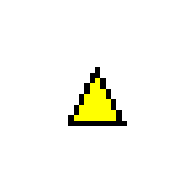


Text 'red circle center' best images:


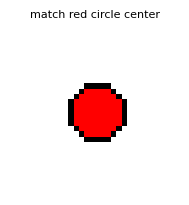

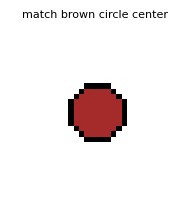

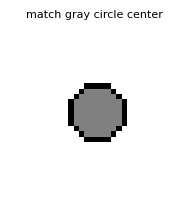

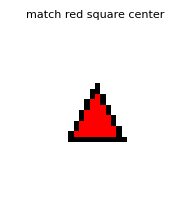

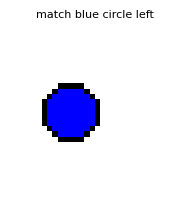

In [51]:
topk_text_for_images(4)

topk_images_for_text(5)